<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Rhea's_Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

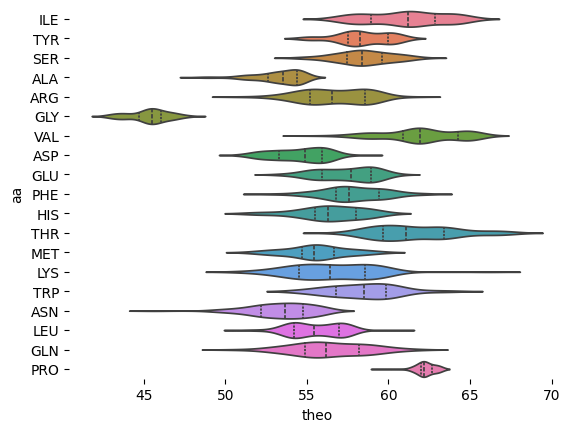

In [ ]:
sns.violinplot(cs_data, x='theo', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

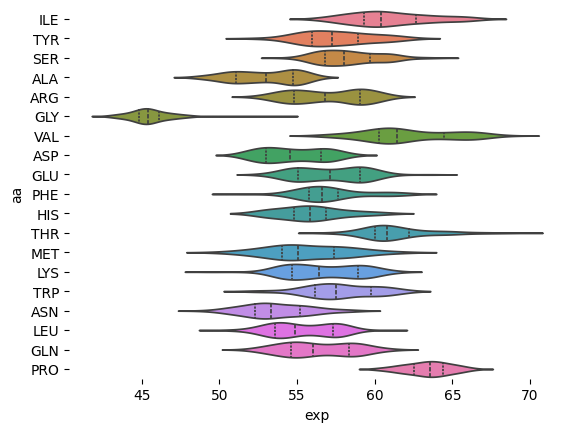

In [ ]:
sns.violinplot(cs_data, x='exp', y='aa', inner='quart', hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

ValueError: cannot insert diff_TminusE, already exists

In [68]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()



Output()

Output()

**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [69]:
with pm.Model(coords=aa_coords) as cs_h_model_t:
    # Hyperpriors for the means and standard deviations
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', sigma=10)

    # Priors for the means (μ) with Student's t distribution
    μ = pm.StudentT('μ',
                    nu=3,  # Degrees of freedom for Student's t distribution
                    mu=μ_mu,
                    sigma=μ_sd,
                    dims="aa")

    # Priors for the standard deviations (σ) with Half-Student's t distribution
    σ = pm.HalfStudentT('σ',
                        nu=3,  # Degrees of freedom for Half-Student's t distribution
                        sigma=10,
                        dims="aa")

    # Likelihood for the data with Student's t distribution
    y = pm.StudentT('y',
                    nu=3,  # Degrees of freedom for the Student's t distribution
                    mu=μ[aa_idx],
                    sigma=σ[aa_idx],
                    observed=cs_data.diff_TminusE)

    # Sample from the posterior distribution
    idata_cs_h = pm.sample()
    idata_cs_h_t = pm.sample()  # Run the Student's t model and store the results


Output()

Output()

Output()

Output()

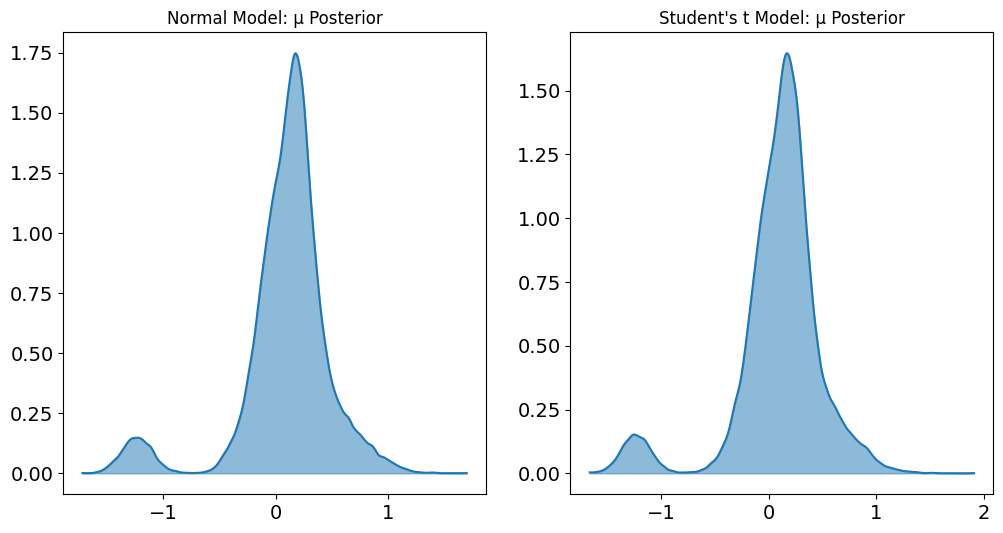

In [70]:
import arviz as az
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

az.plot_kde(idata_cs_h.posterior['μ'].values.flatten(), fill_kwargs={'alpha': 0.5}, ax=axes[0])
axes[0].set_title('Normal Model: μ Posterior')

az.plot_kde(idata_cs_h_t.posterior['μ'].values.flatten(), fill_kwargs={'alpha': 0.5}, ax=axes[1])
axes[1].set_title("Student's t Model: μ Posterior")

plt.show()

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [71]:
with cs_h_model_t:
    posterior_predictive_cs_h = pm.sample_posterior_predictive(idata_cs_h, var_names=["y"])

with cs_h_model_t:
    posterior_predictive_cs_h_t = pm.sample_posterior_predictive(idata_cs_h_t, var_names=["y"])


Output()

Output()

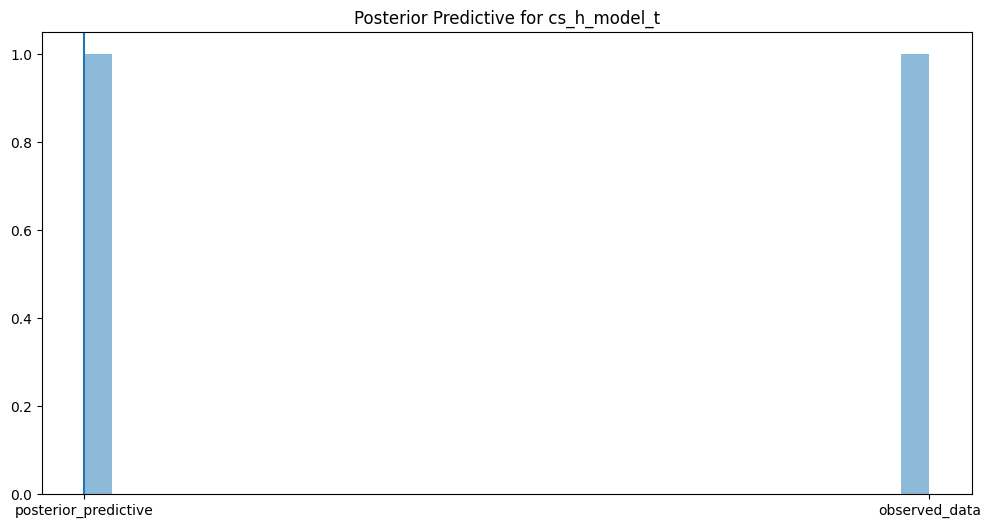

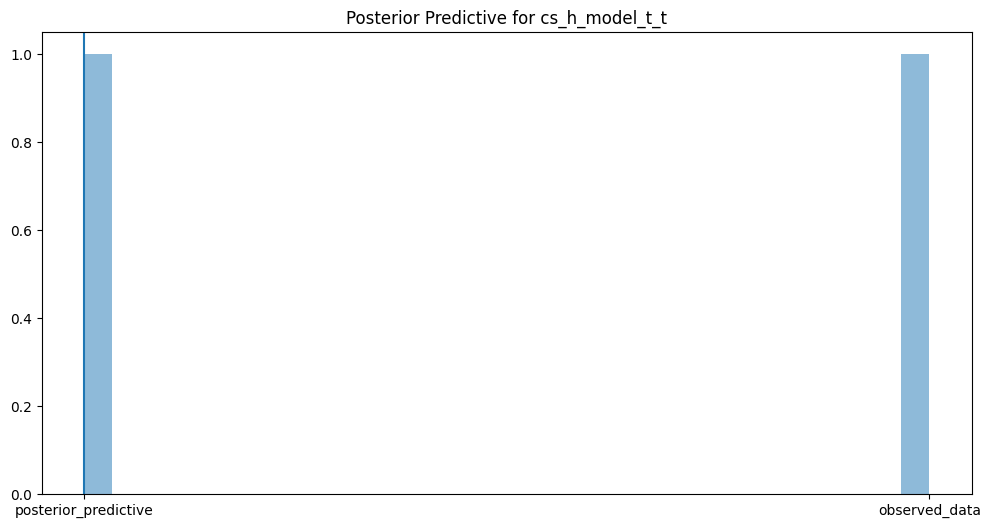

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Plot for the first model
plt.figure(figsize=(12, 6))
plt.hist(posterior_predictive_cs_h, bins=30, alpha=0.5, label='Posterior Predictive cs_h_model_t')
plt.axvline()
plt.title('Posterior Predictive for cs_h_model_t')
plt.show()

# Plot for the second model
plt.figure(figsize=(12, 6))
plt.hist(posterior_predictive_cs_h_t, bins=30, alpha=0.5, label='Posterior Predictive cs_h_model_t_t')
plt.axvline()
plt.title('Posterior Predictive for cs_h_model_t_t')
plt.show()


**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [101]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.003 1.002 1.001 ... 0.9997 1.001 1.0
    μ        float64 8B 1.001
    μ_p      (pos) float64 32B 1.0 1.0 1.053 1.001
    ν        float64 8B 1.005
    ν_p      (pos) float64 32B 1.012 1.001 1.29 1.011


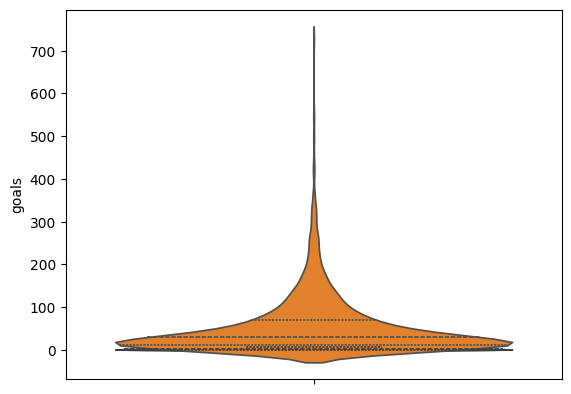

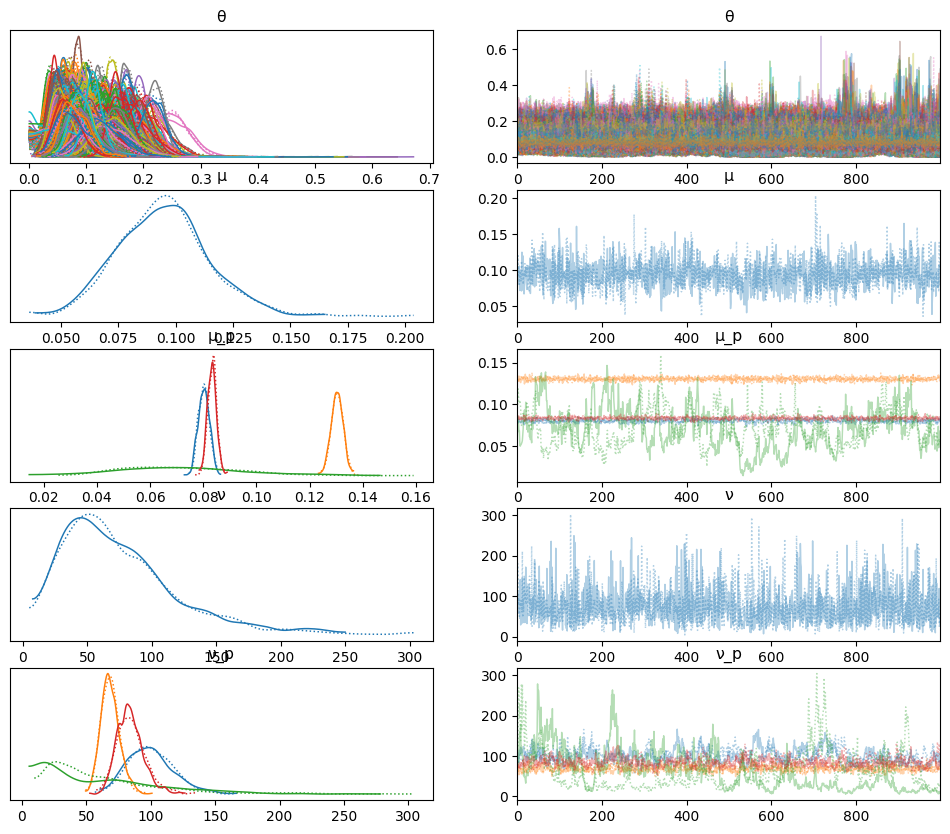

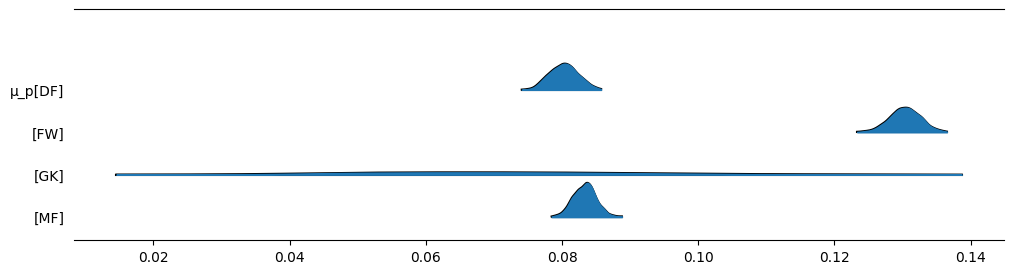

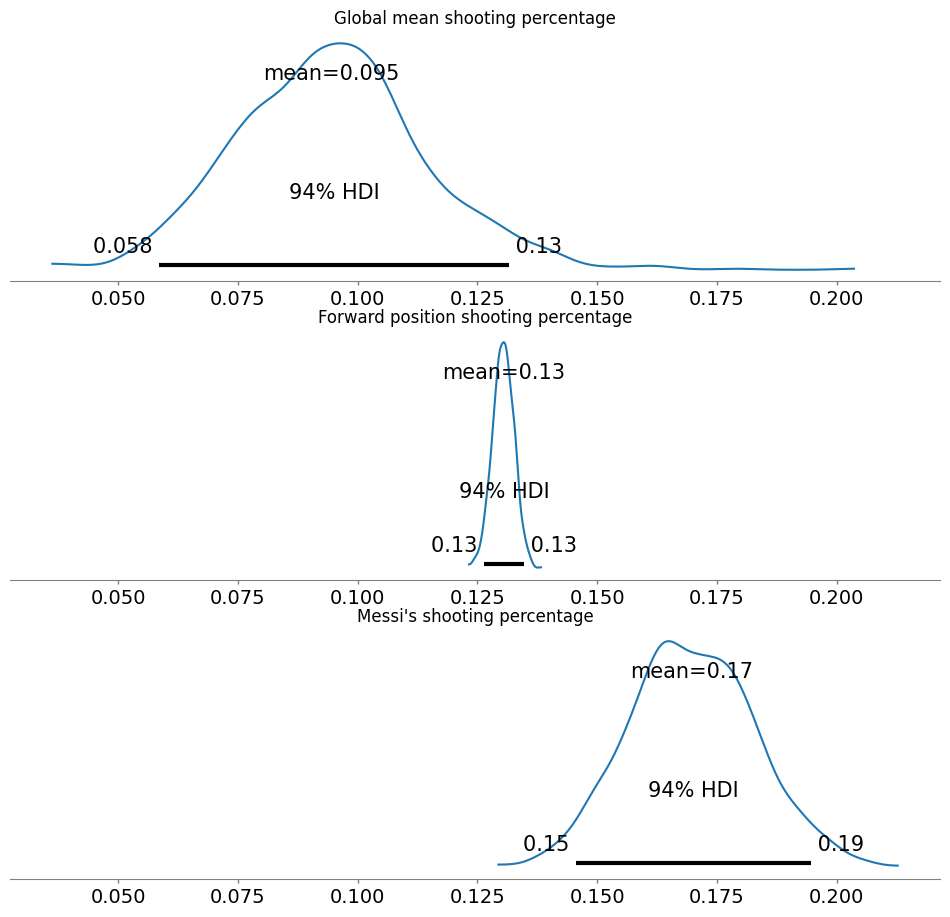

In [102]:
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr, dtype={'position': 'category'})

# Visualize the distribution of goals and shots
sns.violinplot(sccr_data.goals, inner='quart')
sns.violinplot(sccr_data.shots, inner='quart')

pos_idx = sccr_data.position.cat.codes.values

pos_codes = sccr_data.position.cat.categories

sccr_coords = {"pos": pos_codes}

# Create the model with independent groups for each position
with pm.Model(coords=sccr_coords) as sccr_model:
    # Global hyperparameters
    μ = pm.Beta('μ', alpha=2, beta=20)  # Global mean shooting percentage
    ν = pm.Gamma('ν', mu=55, sigma=45)  # Global shooting dispersion

    # Independent parameters for each position
    μ_p = pm.Beta('μ_p', mu=μ, nu=ν, dims='pos')  # Position-specific mean
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims='pos')  # Position-specific variance

    # Parameter for players' shooting probabilities
    θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])

    # Likelihood: Binomial for goals scored based on shots and θ
    _ = pm.Binomial('gs',
                    n=sccr_data.shots.values,  # Shots for each player
                    p=θ,  # Estimated probability of scoring
                    observed=sccr_data.goals.values)  # Observed goals

    # Sampling
    idata_sccr = pm.sample(target_accept=0.95)

# Check the trace and potential issues with sampling
az.plot_trace(idata_sccr)

# Summary of the model with R-hat values
print(az.rhat(idata_sccr))

# Visualize the shooting percentages for each position
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind='ridgeplot', hdi_prob=0.998)

# Prepare a plot for the global mean and specific positions
_, ax = plt.subplots(3, 1, figsize=(12, 11), sharex=True)

# Plot the global mean shooting percentage
az.plot_posterior(idata_sccr, var_names='μ', ax=ax[0])
ax[0].set_title("Global mean shooting percentage")

# Plot the mean shooting percentage for the Forward position
az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title("Forward position shooting percentage")

# Plot the shooting percentage for Lionel Messi
az.plot_posterior(idata_sccr.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title("Messi's shooting percentage")


plt.show()


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?